In [1]:
import warnings; warnings.simplefilter('ignore')

import re
import dlib
import string
import timeit
import pickle
import random
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from sklearn import preprocessing
from matplotlib.pyplot import imshow
from collections import defaultdict, Counter

label_encoder = preprocessing.LabelEncoder()
le = preprocessing.LabelEncoder()
oe = preprocessing.OneHotEncoder()

%matplotlib inline

In [2]:
# Number of examples
N = 5000
# Length of a feature
d = 128
# ICM iterations
NITER = 5

In [3]:
def l2i(a):
        return int(ord(a)-ord('a'))
def i2l(i):
    if i >= 0:
        return chr(i+ord('a'))
    else:
        return '_'
def iors(s):
    try:
        return int(s)
    except ValueError: # if it is a string, return a string
        return s

In [4]:
def read_OCR(filename, n_features):
    F = open(filename)
    dataset = {}
    dataset['ids'] = []#np.zeros(n_examples, dtype=int)
    dataset['labels'] = []#np.zeros(n_examples,dtype=int)
    dataset['labelDic'] = {} # To profile the distribution of labels
    dataset['next_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['word_ids'] = []#np.zeros(n_examples,dtype=int)
    dataset['positions'] = []#np.zeros(n_examples,dtype=int)
    dataset['folds'] = []#np.zeros(n_examples,dtype=int)
    dataset['features'] = []#np.zeros([n_examples,n_features])
    
    for str_line in F.readlines():
        #line0 = map(iors, filter(None, re.split('\t', str_line.strip())))
        ## ATTENTION: If you are using Python3, use the following line instead
        line0 = list(map(iors, filter(None, re.split('\t', str_line.strip()))))


        dataset['ids'].append(int(line0.pop(0)))
        dataset['labels'].append(l2i(line0.pop(0))) # The label is converted into integer('a'=>0, 'z'=>25)
        if dataset['labels'][-1] in dataset['labelDic']:
            dataset['labelDic'][dataset['labels'][-1]] += 1
        else:
            dataset['labelDic'][dataset['labels'][-1]] = 1
            
        dataset['next_ids'].append(int(line0.pop(0)))
        dataset['word_ids'].append(int(line0.pop(0)))
        dataset['positions'].append(int(line0.pop(0)))
        dataset['folds'].append(int(line0.pop(0)))
        if len(line0) != 128:  # Sanity check of the length
            print (len(line0))
        dataset['features'].append(line0)

    return dataset

In [5]:
def structurize(dataset, N, L):
    d_features = len(dataset['features'][0])
    y = dataset['labels']
    X = dataset['features']
    next_id = dataset['next_ids']

    labels = np.zeros((N, L))
    features = np.zeros((N, L*d_features))
    
    # Extract only one structured example
    def extract(iN, loc):
        labels[iN] = y[loc:loc+L]
        features[iN] = np.array(X[loc:loc+L]).ravel().tolist()
        iN += 1
        return iN
    
    iN = 0
    iN = extract(iN, 0)
    
    for key, value in enumerate(y):
        if next_id[key] == -1:
            iN = extract(iN, key+1)
            
            if iN == N:
                break
    
    c = list(zip(labels, features))
    random.shuffle(c)
    labels, features = zip(*c)
    
    return np.array(labels), np.array(features)      

In [6]:
class ThreeClassProblem:
    C = 1

    def __init__(self, samples, labels, L, K, d):
        self.L = L
        self.K = K
        self.d = d
        self.num_samples = len(samples)
        self.num_dimensions = (L*K*d+1) + (L-1)
        self.samples = samples
        self.labels = labels
        self.loss_for_loop = True
        
    def make_psi(self, x, label):       
        psi = dlib.vector()
        psi.resize(self.num_dimensions)
        psi[0] = x[0] # The bias term

        for i in range(self.L):
            for k in range(self.K):
                if (label[i] == k):
                    # i * self.K * self.d + 1= the index of start of current x[i], + 1 due to bias term
                    block_start = i * self.K * self.d + 1
                    # + k * self.d = the index where x[i] starts in its block (due to K off set)
                    offset = k * self.d
                    start_index = block_start + offset
                    for j in range(self.d):
                        psi[start_index + j] = x[i * self.d + 1 + j]
        
        # The last L-1 elements are the transition variables
        for i in range(self.L-1):
            if label[i] != label[i+1]:
                psi[self.K * self.d * self.L + i] = 1.0
            else:
                psi[self.K * self.d * self.L + i] = 0.0
        
        return psi

    def get_truth_joint_feature_vector(self, idx):
        return self.make_psi(self.samples[idx], self.labels[idx])
    
    def separation_oracle(self, idx, current_solution):
        samp = self.samples[idx]
        psi = [0]*self.num_dimensions
        max1 = -1e10
        max_scoring_label = [0]*self.L # Initialize max_scoring_label for icm search
        for k in range(NITER):
            for iL in range(self.L):   # Iterate over the window length
                for i in range(self.K):# Change different label for the search of a structured label
                    tmp_label = max_scoring_label.copy() # New a list to avoid modifying the max_scoring_label
                    tmp_label[iL] = i # Take turns to modify the structured label from left to right. The guessed structured label.
                    tmp_psi = self.make_psi(samp, tmp_label) # Make a new Psi for the guessed structured label
                    score1 = dlib.dot(current_solution, tmp_psi)
                    
                    loss1 = 0.0
                    if self.loss_for_loop:
                        for j in range(self.L):
                            if self.labels[idx][j] != tmp_label[j]:
                                loss1 += 1.0
                    else:
                        if self.labels[idx] != tmp_label: # Add the conditional "1"
                            loss1 += 1.0

                    if max1 < score1+loss1: # Search for the maximum and update loss, max_scoring_label, and psi
                        max1 = score1 + loss1
                        loss = loss1
                        max_scoring_label[iL] = i
                        psi = tmp_psi

        return loss, psi

In [7]:
def predict_words(dataset, L, problem, weights, K):
    words = defaultdict(lambda: {'features': [], 'labels': [], 'next_ids': []})

    # Extract by per word
    for i in range(len(dataset['features'])):
        word_id = dataset['word_ids'][i]
        words[word_id]['features'].append(dataset['features'][i])
        words[word_id]['labels'].append(dataset['labels'][i])
        words[word_id]['next_ids'].append(dataset['next_ids'][i])

    predicted_labels = []
    true_labels = []
    next_ids = []

    # Only consider the first 1000 words for prediction
    words_to_predict = list(words.values())[:1000]

    for word in words_to_predict:
        word_feats = word['features']
        word_labels = word['labels']
        word_next_ids = word['next_ids']
        word_len = len(word_feats)

        if word_len < L:
            continue

        # For each character position, collect {label: list of scores}
        score_votes = [dict() for _ in range(word_len)]

        # Slide window with stride = 1
        for i in range(0, word_len - L + 1):
            x_seq = word_feats[i:i + L]

            # ICM initialization
            prediction = [0] * L

            for _ in range(NITER):
                for iL in range(L):
                    best_label = 0
                    best_score = -1e10
                    for label in range(K):
                        tmp_label = prediction.copy()
                        tmp_label[iL] = label

                        # Flatten and add bias before passing to make_psi
                        x_flat = [1.0] + np.array(x_seq).ravel().tolist()
                        psi = problem.make_psi(x_flat, tmp_label)
                        
                        score = dlib.dot(weights, psi)
                        if score > best_score:
                            best_score = score
                            best_label = label
                    prediction[iL] = best_label

            # Final score for full sequence
            x_flat = [1.0] + np.array(x_seq).ravel().tolist()
            psi_final = problem.make_psi(x_flat, prediction)
            seq_score = dlib.dot(weights, psi_final)

            for j in range(L):
                abs_pos = i + j
                label = prediction[j]
                prev_best = score_votes[abs_pos].get(label, -1e10)
                score_votes[abs_pos][label] = max(prev_best, seq_score)

        # Final prediction: pick label with highest max score at each position
        word_pred = []
        for label_score_dict in score_votes:
            if not label_score_dict:
                word_pred.append(0)
            else:
                best_label = max(label_score_dict.items(), key=lambda x: x[1])[0]
                word_pred.append(best_label)

        predicted_labels.extend(word_pred)
        true_labels.extend(word_labels)
        next_ids.extend(word_next_ids)

    return predicted_labels, true_labels, next_ids

In [8]:
def full_word_accuracy(predicted_labels, true_labels, next_ids):
    assert len(predicted_labels) == len(true_labels) == len(next_ids)

    pred_words = []
    true_words = []

    pred_buffer = []
    true_buffer = []

    for pred, truth, nxt in zip(predicted_labels, true_labels, next_ids):
        pred_buffer.append(pred)
        true_buffer.append(truth)

        if nxt == -1:
            pred_words.append(pred_buffer)
            true_words.append(true_buffer)
            pred_buffer = []
            true_buffer = []

    assert len(pred_words) == len(true_words)

    correct = sum(p == t for p, t in zip(pred_words, true_words))
    total = len(true_words)
    return correct / total if total > 0 else 0.0

In [9]:
def cal_accuracy(samples, labels, problem, weights, K):
    predictions = []
    for samp in samples:
        prediction = [0]*problem.L # Initialize max_scoring_label for icm search
        for k in range(NITER):
            for iL in range(problem.L):
                max = -1e10
                for i in range(K):
                    tmp_label = prediction.copy()
                    tmp_label[iL] = i
                    psi1 = problem.make_psi(samp, tmp_label)
                    score = dlib.dot(weights, psi1)

                    if max < score:
                        max = score
                        prediction[iL] = i
        predictions.append(prediction)
    
    
    errCnt = 0
    for i in range(len(predictions)):
        if predictions[i] != labels[i]:
            errCnt += 1

    return 1.0-float(errCnt)/float(len(predictions))

In [ ]:
def showFeatures(features, true_labels, predicted_labels, num=20):
    plt.figure(figsize=(num, 4))

    for i in range(num):
        npfeature = np.array(features[i])
        image = npfeature.reshape(16, 8)

        true_char = i2l(true_labels[i])
        pred_char = i2l(predicted_labels[i])

        plt.subplot(1, num, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"T:{true_char}\nP:{pred_char}", fontsize=8)
        plt.axis('off')

    plt.suptitle("Character Predictions — T: Truth, P: Predicted", fontsize=12)
    plt.tight_layout()
    plt.show()

In [11]:
dataset = read_OCR('OCRdataset/letter.data', d)

## L = 1

In [15]:
L = 1

### 4000/1000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.8
model_path = 'ssvm1_82.obj'

In [17]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 13


In [14]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 90.7213495420001 s


Training accuracy= 0.694
Test accuracy= 0.6890000000000001
Testing time elapsed: 2.818789375014603 s
Prediction time elapsed: 24.931321916985326 s
Full word accuracy: 0.0


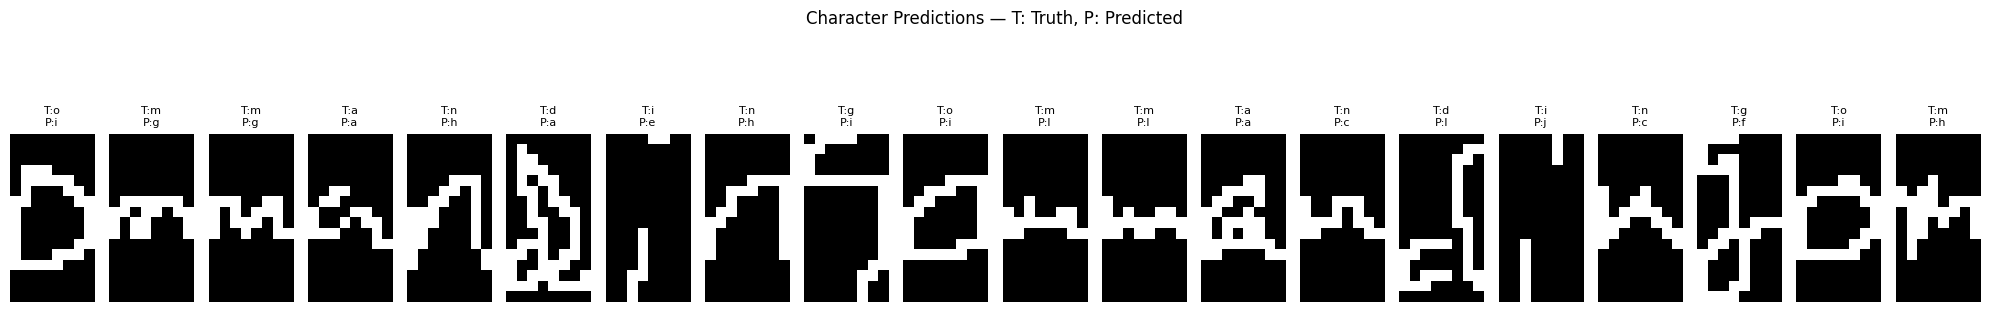

In [18]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

### 2500/2500

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.5
model_path = 'ssvm1_55.obj'

In [20]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 13


In [18]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 53.408922875001736 s


Training accuracy= 0.69
Test accuracy= 0.7044
Testing time elapsed: 7.094120207999367 s
Prediction time elapsed: 24.417175375012448 s
Full word accuracy: 0.0


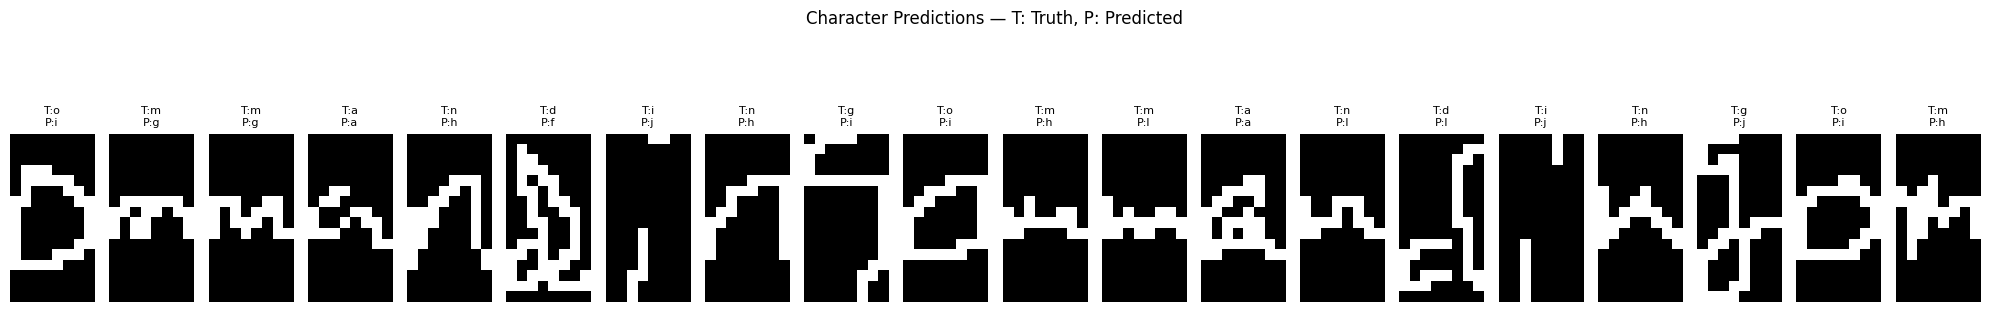

In [21]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

#### 1000/4000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.2
model_path = 'ssvm1_28.obj'

In [23]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 13


In [22]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 23.554695332997653 s


Training accuracy= 0.69
Test accuracy= 0.7110000000000001
Testing time elapsed: 11.891794791998109 s
Prediction time elapsed: 24.641953166981693 s
Full word accuracy: 0.0


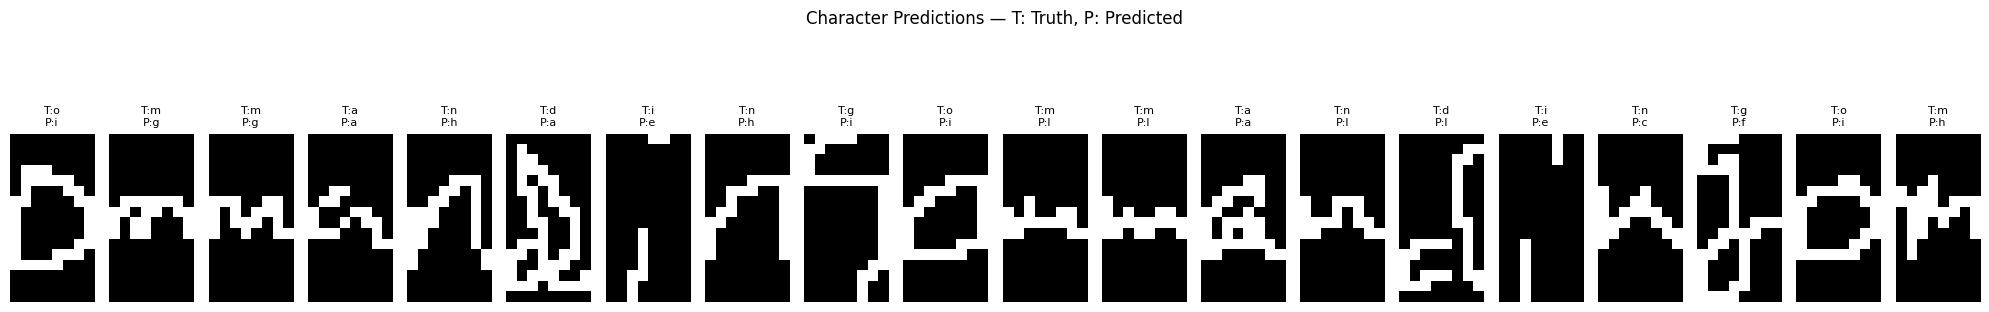

In [24]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

## L = 2

In [80]:
L = 2

### 4000/1000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.8
model_path = 'ssvm2_82.obj'

In [27]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 23


In [27]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 930.3678602500004 s


Training accuracy= 0.48850000000000005
Test accuracy= 0.474
Testing time elapsed: 19.77340591698885 s
Prediction time elapsed: 147.96682787500322 s
Full word accuracy: 0.0


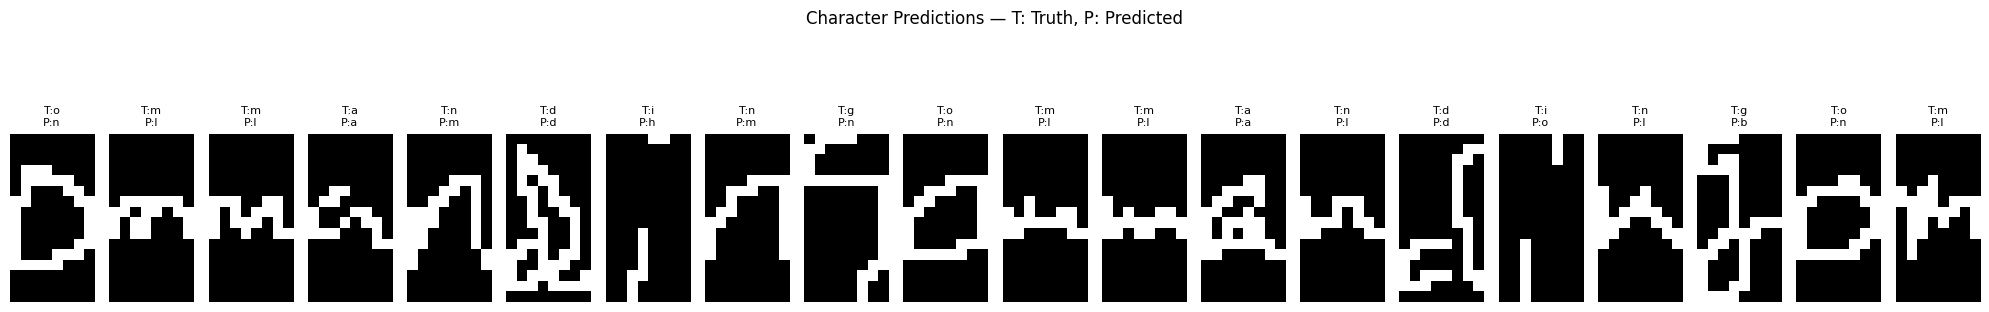

In [28]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

### 2500/2500

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.5
model_path = 'ssvm2_55.obj'

In [30]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 23


In [31]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 554.2961782499988 s


Training accuracy= 0.48160000000000003
Test accuracy= 0.47319999999999995
Testing time elapsed: 49.89197941601742 s
Prediction time elapsed: 147.4011102920049 s
Full word accuracy: 0.0


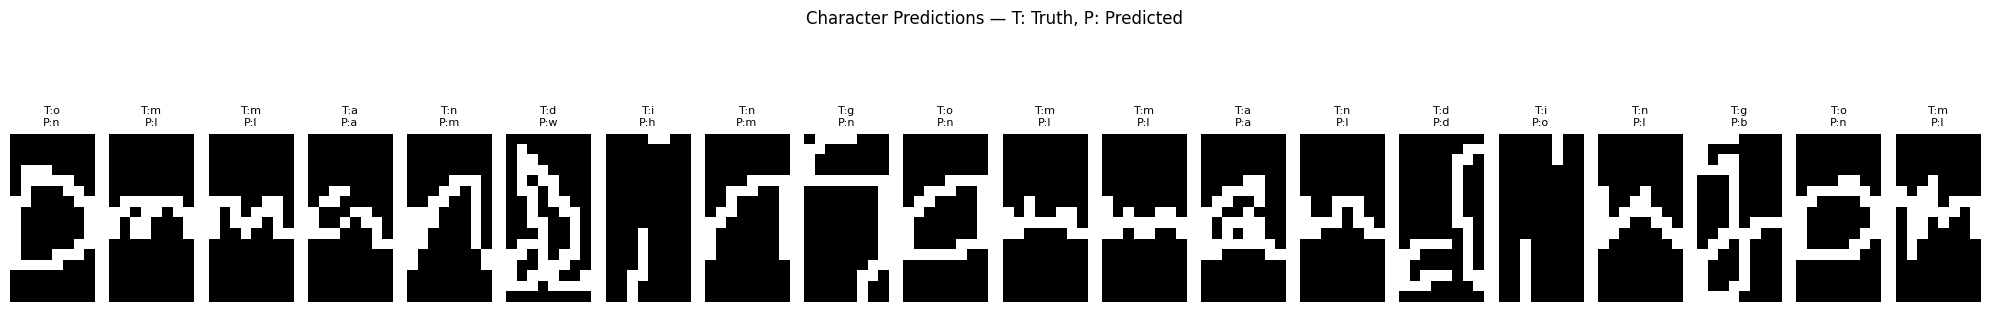

In [31]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

#### 1000/4000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.2
model_path = 'ssvm2_28.obj'

In [33]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 23


In [35]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 221.97689133299718 s


Training accuracy= 0.47
Test accuracy= 0.45099999999999996
Testing time elapsed: 81.52147916698596 s
Prediction time elapsed: 153.72042170798522 s
Full word accuracy: 0.0


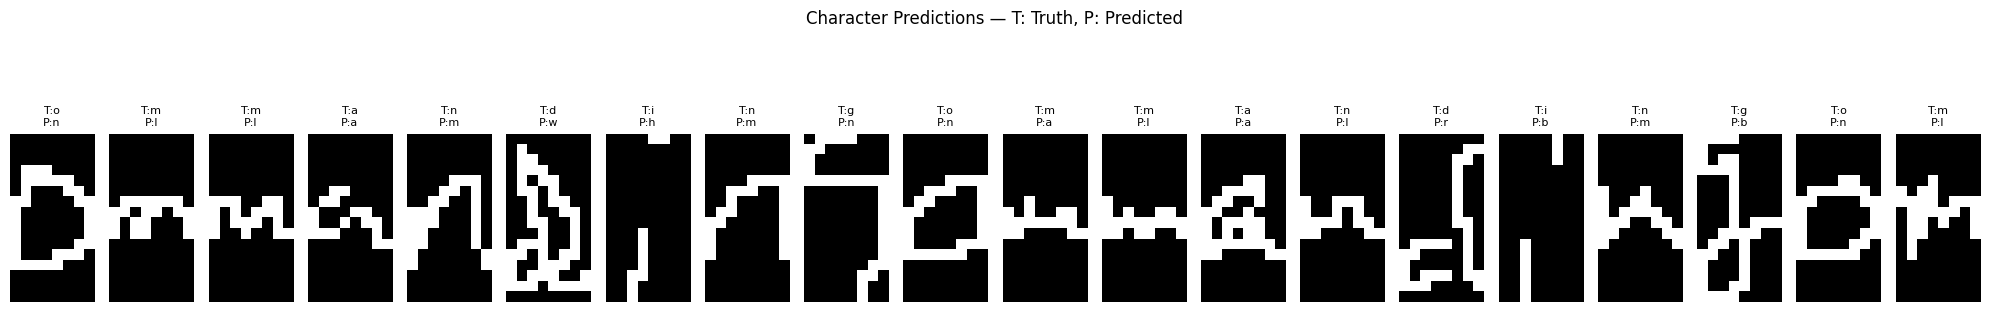

In [34]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

## L = 3

In [12]:
L = 3

### 4000/1000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.8
model_path = 'ssvm3_82.obj'

In [77]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 24


In [78]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 2399.4129877090163 s


Training accuracy= 0.0
Test accuracy= 0.0
Testing time elapsed: 44.619902708014706 s
Prediction time elapsed: 279.93059095798526 s
Full word accuracy: 0.0


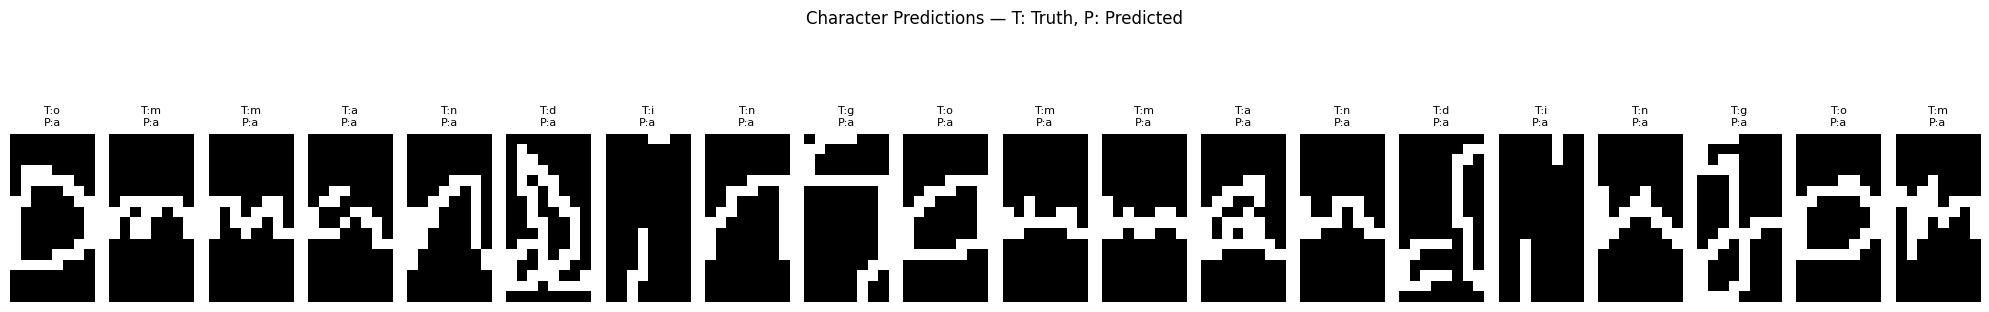

In [79]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

### 2500/2500

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.5
model_path = 'ssvm3_55.obj'

In [15]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 24


In [16]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 1653.5220660410123 s


Training accuracy= 0.3456
Test accuracy= 0.2972
Testing time elapsed: 121.15170024998952 s
Prediction time elapsed: 289.9325836249918 s
Full word accuracy: 0.0


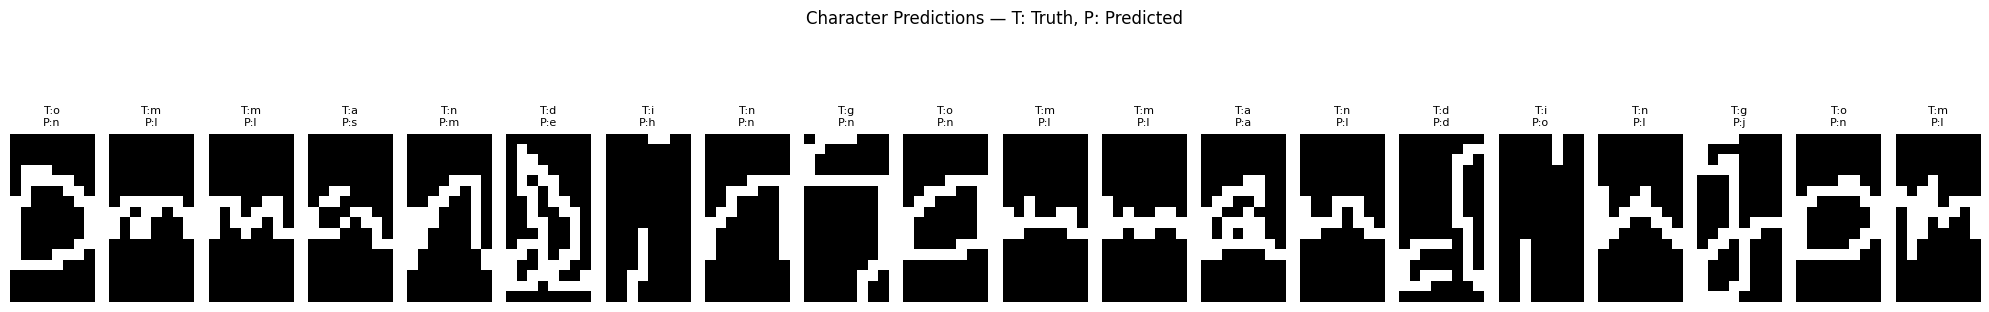

In [17]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)

#### 1000/4000

In [ ]:
# Setup
labels, features = structurize(dataset, N, L)
TRAIN = 0.2
model_path = 'ssvm3_28.obj'

In [19]:
le = preprocessing.LabelEncoder()
nplabels  = le.fit_transform(labels.ravel()).reshape(labels.shape)
npsamples = np.hstack([np.ones((N,1)), features]) # Add ones for bias
K = len(le.classes_)
print ('K=', K)

tr_labels  = nplabels[:int(N*TRAIN)].astype(int).tolist()
tr_samples = npsamples[:int(N*TRAIN)].astype(int).tolist()
te_labels  = nplabels[int(N*TRAIN):].astype(int).tolist()
te_samples = npsamples[int(N*TRAIN):].astype(int).tolist()

problem = ThreeClassProblem(tr_samples, tr_labels, L, K, d)

K= 24


In [20]:
start_train = timeit.default_timer()
weights = dlib.solve_structural_svm_problem(problem)
end_train = timeit.default_timer()
print ("Training time elapsed:", end_train - start_train, "s")
pickle.dump(weights, open(model_path, 'wb'))

Training time elapsed: 685.5196417499974 s


Training accuracy= 0.40700000000000003
Test accuracy= 0.281
Testing time elapsed: 189.4410084580013 s
Prediction time elapsed: 308.7405513749982 s
Full word accuracy: 0.0


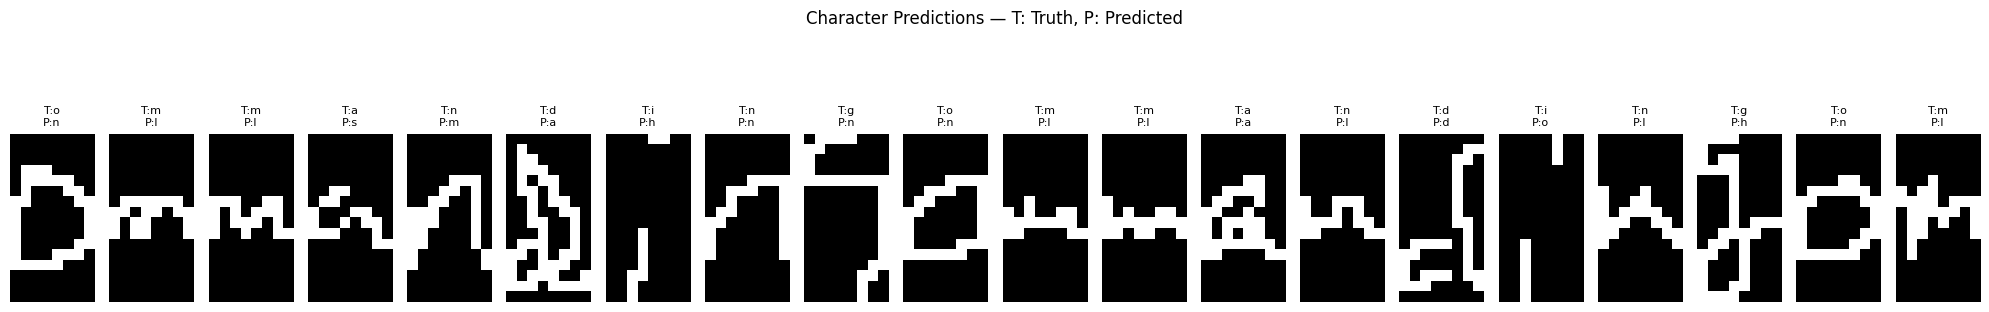

In [21]:
weights_load = pickle.load(open(model_path,'rb'))

print ("Training accuracy=", cal_accuracy(tr_samples, tr_labels, problem, weights_load, K))
start_test = timeit.default_timer()
print ("Test accuracy=", cal_accuracy(te_samples, te_labels, problem, weights_load, K))
end_test = timeit.default_timer()
print ("Testing time elapsed:", end_test - start_test, "s")

start_predict = timeit.default_timer()
predicted_labels, true_labels, next_ids = predict_words(dataset, L, problem, weights_load, K)
end_predict = timeit.default_timer()
print ("Prediction time elapsed:", end_predict - start_predict, "s")
full_accuracy = full_word_accuracy(predicted_labels, true_labels, next_ids)
print ("Full word accuracy:", full_accuracy)

showFeatures(dataset['features'], true_labels, predicted_labels, num=20)